In [5]:
#### ILI-AII-Pneumonia-Weather 2016-2018 LSTM-n -- FORECAST BASED ON n PERIODS

#########################################################
# GENERAL MODEL PARAMETERS
#########################################################

import sys
sys.path.insert(0, '../')

import pandas as pd

# Perform Target Smoothing with Savitsky-Golay
smoothing = 5 # window for the rolling average

### move the rolling average up
predict_days = 7 # 7 ---> (t+7) [THESE ARE PERIODS - CAN BE DAYS OR WEEKS DEPENDING ON THE MODEL]

# specify the number of lag days (t-1), (t-2), ... (t-n_lag)
n_days = 28 # 7 ---> (t+7) [THESE ARE PERIODS - CAN BE DAYS OR WEEKS DEPENDING ON THE MODEL]

# Keep data columns for weather or age groups

#########################################################
# FEATURES
#########################################################

include_weather = True  # U, T 9, 13-30, 18, 21
include_weather_inside_relative_humidity = False
include_weather_ITF = False
include_age_groups = False
include_case_count_year_before = False
include_case_count_diff = 7

include_day_off = True  # Sat + Sun
include_day_off_sat = False
include_day_off_sun = False

include_school_breaks = True
include_holiday = True

outlier_suppress = True  # 2009

include_case_counts = False 

normalize_features = True

# Keep either only aggregate part or daily part or both ...
Aggregate_Part = True
Daily_Part = True

aggregate_cases = True  # convert into weekly from daily

substract_seasonal = False # Substract seasonal (seasonal-trend-residual)
split_seasonal_residuals = False 
add_ili_counts = False # Add ILI counts to improve forecasting (pneumonia)

#########################################################
# DATA
#########################################################

Disease_ILI = "Influenza Like Ilness"

#Disease = "Pneumonia"
#Disease = "Acute Intestinal Infections"
Disease = Disease_ILI

#########################################################
# ANN PARAMETERS
#########################################################

epochs_number = 100
model_type = 5
ModelNeuronsQty = 15
n_dropout = 0.0

Comment = ""

import numpy
import datetime as dt
from pandas import read_csv
from matplotlib import pyplot
from common import savitzky_golay
from common import supress_outliners
from common import plot_columns
from common import series_to_supervised
from common import mean_absolute_percentage_error
%matplotlib inline

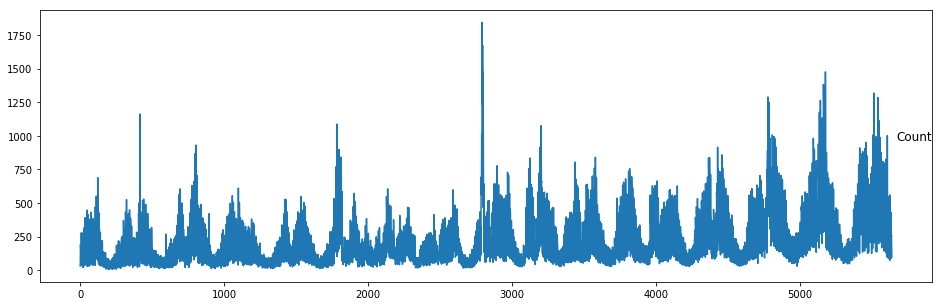

In [7]:
agg_dataset = read_csv('yakutsk-daily-age-groups-2001-2018.csv', header=0, index_col=0)
agg_dataset.rename(columns={"Case No_count": "Count"}, inplace=True)


# Supress outliers
if outlier_suppress == True:
    supress_outliners(agg_dataset, "Count")
    
count_dataset = agg_dataset[["Count"]]

plot_columns(count_dataset, [0])


In [8]:
#заполнение пропущенных значений. берется среднее значение среди всех годов для этого дня этой недели
index = count_dataset['Count'].index[count_dataset['Count'].apply(numpy.isnan)]
df_index = count_dataset.index.values.tolist()
empty_positions = [df_index.index(i) for i in index]

average_count_values = numpy.empty(len(empty_positions))

year_length = 366
year_count = int(len(count_dataset)/year_length) + 1
empty_year_positions = [position % year_length  for position in empty_positions]
mean_values = []
for position in empty_year_positions:
    
    position_week_day = agg_dataset["day"][position]
    position_year_week = agg_dataset["epi_week"][position]
    
    print("try to find position_week_day={}, position_year_week={}".format(position_week_day, position_year_week))
    
    elements_for_mean = []
    
    for year_number in range(year_count):
        
        
        year_offset = year_number * year_length
        year_position =  year_offset + position
        
        position_year_slice = agg_dataset[year_position - 4 - year_number: year_position + 4 - year_number]
        
        for i in range(len(position_year_slice)):
            item = position_year_slice.iloc[[i]]    
            if item.get("isoWeek")[0] == position_year_week and item.get("day")[0] == position_week_day:
                count = item.get("Count")[0]
                elements_for_mean.append(count)
                print("found item for year={}, count={}".format(year_number, count))
                break
                
    elements_for_mean = [x for x in elements_for_mean if ~numpy.isnan(x)]
    mean_values.append(numpy.mean(elements_for_mean))
    
filled_dataset = count_dataset.copy()

print(mean_values)

filled_dataset.iloc[empty_positions,0] = mean_values

[]


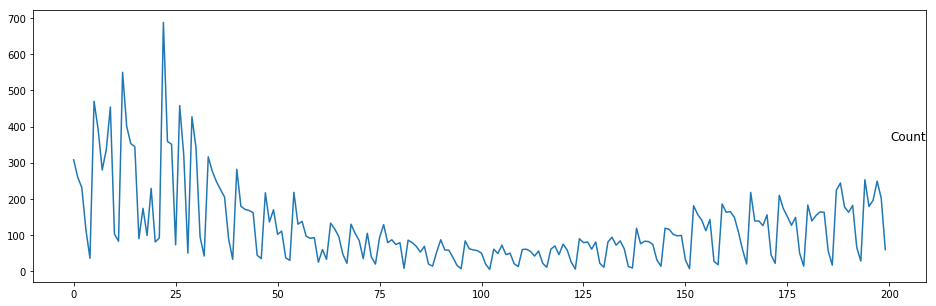

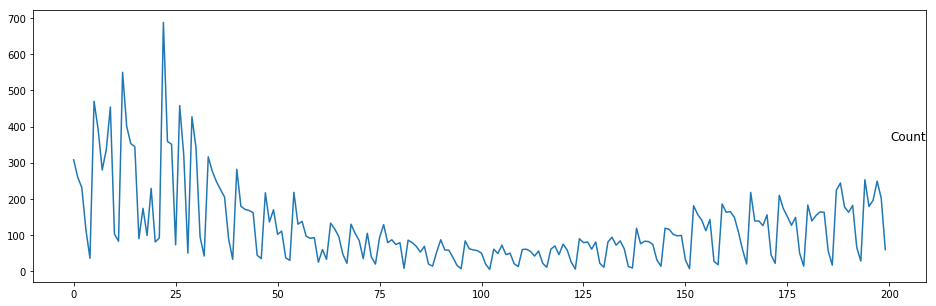

In [9]:
plot_columns(count_dataset[100:300], [0])
plot_columns(filled_dataset[100:300], [0])

In [10]:
# MERGE WITH WEATHER DATA

import pandas as pd

cols = list(filled_dataset)
cols.insert(0, cols.pop(cols.index('Count')))
dataset = filled_dataset.loc[:, cols]


# Perform Target Smoothing with RA
# INPUT: rolling_window # window for the rolling average

# prepare the target column

if smoothing > 0 :
    dataset['Case No_RM'] = savitzky_golay(dataset['Count'].values,smoothing,2)
else:
    dataset['Case No_RM'] = dataset['Count']
    
dataset['Case_Actuals'] = dataset['Count']
    

# Replace weather part of the dataset w/ weather
    
weather_dataset = pd.read_csv('weather-09-1330-18.csv', index_col=0, sep=',')

weather_dataset.fillna(0, inplace=True)
dataset = dataset.join(weather_dataset)

dataset.tail(10)

,Count,Case No_RM,Case_Actuals,ITF09,ITF1330,ITF18,ITF21,RH09,RH1330,RH18,...,RHTR18,RHTR21,T09,T1330,T18,T21,U09,U1330,U18,U21
LT,,,,,,,,,,,,,,,,,,,,,
2018-05-25,264.0,257.657143,264.0,97.244079,61.222222,49.066667,88.691849,27.805099,20.000000,21.000000,...,21.0,28.0,18.9,24.70,26.1,21.7,35.0,20.0,21.0,28.0
2018-05-26,188.0,149.085714,188.0,88.691849,62.966667,61.400000,89.013058,26.048255,22.000000,19.000000,...,19.0,23.0,21.7,24.35,24.6,19.6,28.0,22.0,19.0,23.0
2018-05-27,86.0,204.200000,86.0,94.940506,63.455556,46.600000,99.000000,24.940506,21.000000,21.000000,...,21.0,37.0,19.7,24.35,26.4,20.5,30.0,21.0,21.0,37.0
2018-05-28,430.0,302.200000,430.0,73.700000,47.425000,40.434085,45.339764,31.000000,25.500000,39.963213,...,54.5,84.0,23.3,25.75,17.5,10.0,31.0,25.5,54.5,84.0
2018-05-29,313.0,380.114286,313.0,86.202643,86.957808,87.735726,90.015029,16.202643,16.957808,17.735726,...,34.0,42.0,10.2,11.45,11.7,10.2,34.0,33.0,34.0,42.0
2018-05-30,319.0,288.657143,319.0,89.510531,89.676732,89.251443,94.411186,19.510531,19.676732,19.251443,...,32.0,50.0,7.6,12.25,14.1,10.6,48.0,36.5,32.0,50.0
2018-05-31,249.0,275.485714,249.0,96.278021,93.559659,91.172606,92.390718,26.597527,23.559659,21.172606,...,26.5,29.0,13.8,19.60,19.0,18.4,45.0,28.5,26.5,29.0
2018-06-01,258.0,240.771429,258.0,95.415481,95.351256,62.533333,95.923732,25.519351,25.439070,16.000000,...,16.0,32.0,15.1,20.05,24.2,19.4,40.0,30.0,16.0,32.0
2018-06-02,192.0,177.514286,192.0,86.298710,90.422872,90.686824,95.529395,16.298710,20.422872,20.686824,...,33.0,51.0,14.8,15.65,14.8,11.1,26.0,31.0,33.0,51.0


In [11]:
#Add calendar info

epi_calendar = read_csv('epi_calendar.csv', header=0, index_col=0)
epi_calendar['epi_year_week'] = epi_calendar.index
epi_calendar.set_index('date.1',inplace=True)
epi_calendar.drop(['epi_year_week'], axis=1, inplace=True) 
dataset = dataset.join(epi_calendar)


In [12]:
len(dataset.columns)

33

In [13]:
all_columns = [i for i in range(len(dataset.columns))]

plot_columns(dataset, all_columns, column_height = 1.5)

KeyboardInterrupt: 

In [14]:
# Substract seasonal from the dataset
import statsmodels.api as sm

case_count = dataset['Count']
decomposed = sm.tsa.seasonal_decompose(case_count.values, freq=52)

residual = decomposed.resid
seasonal = decomposed.seasonal
trend = decomposed.trend

if substract_seasonal == True or split_seasonal_residuals == True:
    
    dataset['Case No_count'] -= seasonal # only residual left
    
if substract_seasonal == True:

    dataset['Case No_RM'] -= seasonal
    
if split_seasonal_residuals == True:
    
    dataset['Seasonal_count'] = seasonal # seasonal counts

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


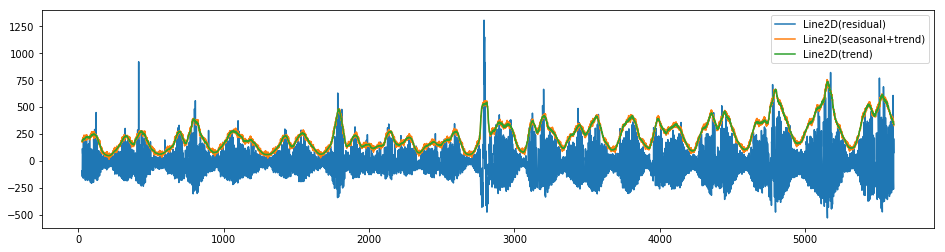

In [15]:
pyplot.figure(figsize=(16, 4))
residual_plot, = pyplot.plot(residual, label='residual')
seasonal_plot, = pyplot.plot(seasonal+trend, label = 'seasonal+trend')
trend_plot, = pyplot.plot(trend, label='trend')
pyplot.legend([residual_plot, seasonal_plot, trend_plot])
#pyplot.plot(seasonal+trend+residual)

In [16]:
# Year-back feature for weekly dataset ...
# Year-back feature for daily dataset ...

dataset['Case Count Year Before'] = dataset['Case No_RM']
values = dataset['Case Count Year Before'].values

back_delta = 365
for i in range(back_delta,len(values)):
    values[i] -= values[i-back_delta]
values[0:back_delta] = 0

dataset['Case Count Year Before'] = values

# Case count difference ...

dataset['case_count_diff'] = 0.0
if include_case_count_diff > 0:
    dataset['case_count_diff'] = dataset['Case No_RM'] - dataset['Case No_RM'].shift(include_case_count_diff)
    dataset.fillna(0, inplace=True)  # fill leading N/A 

In [17]:
# MAKE 'Case No_RM' the last column

columns = [column for column in dataset if column != 'Case No_RM'] + ['Case No_RM']
dataset = dataset[columns]
dataset.columns

Index(['Count', 'Case_Actuals', 'ITF09', 'ITF1330', 'ITF18', 'ITF21', 'RH09',
       'RH1330', 'RH18', 'RH21', 'RHTR09', 'RHTR1330', 'RHTR18', 'RHTR21',
       'T09', 'T1330', 'T18', 'T21', 'U09', 'U1330', 'U18', 'U21', 'date',
       'day', 'iso_week', 'epi_week', 'epi_year', 'day_off', 'break_day',
       'holiday', 'day_off_sat', 'day_off_sun', 'Case Count Year Before',
       'case_count_diff', 'Case No_RM'],
      dtype='object')

In [21]:
# PREPARE AND CONVERT FOR SUPERVISED LEARNING

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

dataset.fillna(0,inplace=True)

#dataset.drop(['T_mean'], axis=1, inplace=True)

if include_weather == False :
    dataset.drop(['T09', 'U09', 'T1330', 'U1330', 'T18', 'U18'], axis=1, inplace=True, errors='ignore')
if include_weather_inside_relative_humidity == False:
    dataset.drop(['RHTR09', 'RHTR1330', 'RHTR18', 'RH09', 'RH1330', 'RH18'], axis=1, inplace=True, errors='ignore')
if include_weather_ITF == False:
    dataset.drop(['ITF09', 'ITF1330', 'ITF18'], axis=1, inplace=True, errors='ignore')
    
if include_case_count_year_before == False:
    dataset.drop(['Case Count Year Before'], axis=1, inplace=True, errors='ignore')

if include_day_off == False:
    dataset.drop(['day_off'], axis=1, inplace=True, errors='ignore')    

if include_school_breaks == False:
    dataset.drop(['break_day'], axis=1, inplace=True, errors='ignore') 
    
if include_holiday == False:
    dataset.drop(['holiday'], axis=1, inplace=True, errors='ignore') 

if include_day_off_sat == False:
    dataset.drop(['day_off_sat'], axis=1, inplace=True, errors='ignore') 

if include_day_off_sun == False:
    dataset.drop(['day_off_sun'], axis=1, inplace=True, errors='ignore') 

if include_case_count_diff > 0:
    dataset.drop(['case_count_diff'], axis=1, inplace=True, errors='ignore')
    
values = dataset.values
dataset.drop(['date'], axis = 1, inplace = True, errors='ignore')

print(dataset.columns)

# ensure all data is float
values = values.astype('float64')
# normalize features
if normalize_features == True:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
else:
    scaled=values

# frame as supervised learning
# INPUT: n_days = 7 ### 7 days = week, 14 days = 2 weeks

n_features = len(dataset.columns) - 1
print('feature_count=', str(n_features))
reframed = series_to_supervised(scaled, n_days, 1)

# drop (t-7), (t-6), ...(t-1) targets leaving only the (t) target as the last column

# print("dropped colums: ")
for i in range(n_days,0,-1):
    reframed.drop(reframed.columns[i*(n_features+1)-1], axis=1, inplace=True)
    # print(str(i*n_features),':', str(i), " | ")

# drop (t) vector except the target
reframed.drop(reframed.columns[numpy.arange(len(reframed.columns)-n_features-1,len(reframed.columns)-1)], axis=1, inplace=True)
print("dropped column: " + str(numpy.arange(len(reframed.columns)-n_features-1,len(reframed.columns)-1)) )

#shift the targets by predict days...

#reframed.iloc[ :, -1:] = reframed.iloc[ :, -1:].shift(periods=-predict_days+1)
values = reframed.values
if predict_days-1 > 0 :
    values[:-predict_days+1,-1] = values[predict_days-1:,-1]
    
print("shifted for prediction by (days):" + str(predict_days))

# Actuals ...
valuesA = dataset [['Case_Actuals']][n_days:].values  # shift to the left replacing first n_days
valuesA = valuesA.astype('float64')

# Dates of the set
valuesDates = dataset.index[n_days:].values

valuesF = dataset[n_days:].values  # shift to the left replacing first n_days
valuesF = valuesF.astype('float64')

Index(['Count', 'Case_Actuals', 'ITF21', 'RH21', 'RHTR21', 'T09', 'T1330',
       'T18', 'T21', 'U09', 'U1330', 'U18', 'U21', 'day', 'iso_week',
       'epi_week', 'epi_year', 'day_off', 'break_day', 'holiday',
       'Case No_RM'],
      dtype='object')
feature_count= 20
dropped column: [540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557
 558 559]
shifted for prediction by (days):7


In [22]:
# SPLIT INTO TRAINING-VALIDATION-TEST DATASETS

# split into train and test sets

# CUT THE CASE-BASED PART

if Daily_Part == False  :
    values = values[: -len(cases_dataset)] # !!!! CUT OUT THE DAILY DATASET !!!!
    valuesA = valuesA[: -len(cases_dataset)]
    valuesF = valuesF[: -len(cases_dataset)]
    valuesDates = valuesDates[: -len(cases_dataset)]
if Aggregate_Part == False :
    values = values[-len(cases_dataset): ] # !!!! CUT OUT AGGREGATE DATASET !!!!
    valuesA = valuesA[-len(cases_dataset): ]
    valuesF = valuesF[-len(cases_dataset): ]
    valuesDates = valuesDates[-len(cases_dataset): ]
    
#n_train_days = int((len(values) )* 0.6)
#n_test_days = int((len(values)) * 0.08) # 5% -> 8%
n_train_days = int((len(values) )* 0.67)
n_test_days = int((len(values)) * 0.08)

train = values[:n_train_days, :]
trainA = valuesA[:n_train_days, :]
trainF = valuesF[:n_train_days, :]
trainDates = valuesDates[:n_train_days]

test = values[n_train_days:n_test_days+n_train_days, :]
testA = valuesA[n_train_days:n_test_days+n_train_days, :]
testF = valuesF[n_train_days:n_test_days+n_train_days, :]
testDates = valuesDates[n_train_days:n_test_days+n_train_days]

#test2 = values[n_test_days+n_train_days:, :]
#test2A = valuesA[n_test_days+n_train_days:, :]
#test2F = valuesF[n_test_days+n_train_days:, :]
#test2Dates = valuesDates[n_test_days+n_train_days:]

test2 = values[n_train_days:, :]
test2A = valuesA[n_train_days:, :]
test2F = valuesF[n_train_days:, :]
test2Dates = valuesDates[n_train_days:]

n_test2_days = len(test2)
print("n_train_days=", n_train_days, ", n_test_days=", n_test_days, ', n_test2_days=', n_test2_days)
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
test2_X, test2_y = test2[:, :n_obs], test2[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
test2_X = test2_X.reshape((test2_X.shape[0], n_days, n_features))
print('train_X.shape = ', train_X.shape, 'train_y.shape=' , train_y.shape)
print('test_X.shape=', test_X.shape, 'test_y.shape=', test_y.shape)
print('test2_X.shape=', test2_X.shape, 'test2_y.shape=', test2_y.shape)

n_train_days= 3759 , n_test_days= 448 , n_test2_days= 1852
(3759, 560) 3759 (3759,)
train_X.shape =  (3759, 28, 20) train_y.shape= (3759,)
test_X.shape= (448, 28, 20) test_y.shape= (448,)
test2_X.shape= (1852, 28, 20) test2_y.shape= (1852,)


In [23]:
# TRAIN AND VALIDATE THE NETWORK


from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.layers import Dense, Activation, Dropout,LSTM
import keras.backend as K
import keras

import datetime as dt


print(train_y.shape[0])

# define custom loss function
def amae(a, p):
    xproduct = K.concatenate([a[:,:1],a[:,1:] - a[:,:-1]])#
#    xproduct = -xproduct
    xproduct *= -0.
    xdelta = p - a
    xdelta = K.abs(xdelta) + xdelta * xproduct
#    product = K.concatenate(a[:,0], a[:,1:] - a[:,:-1])
#    product[0] = 0
#    product = - product * 10
#    delta = p - a
#    delta = abs(delta) + (delta * product)
#    return sum(delta)/len(delta)

    return K.mean(xdelta)
   
 
# design network
model = Sequential()


if model_type == 1:
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(ModelNeuronsQty))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
#####model.compile(loss=amae, optimizer='adam')

if model_type == 0:
    model.add(LSTM(ModelNeuronsQty, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')


if model_type == 3:
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

if model_type == 2:
    model.add(LSTM(20, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(n_dropout))
    model.add(LSTM(15))
    model.add(Dropout(n_dropout))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mae', optimizer='RMSprop')

if model_type == 4:
    model.add(LSTM(256, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(Dense(1))
 #   model.add(Activation('relu'))
    model.compile(loss='mae', optimizer='adam')

if model_type == 5:
    model.add(LSTM(20, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(n_dropout))
    model.add(LSTM(15))
    model.add(Dropout(n_dropout))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')

if model_type == 6:
    model.add(LSTM(25, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(25))
    model.add(Dropout(0.15))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

if model_type == 7:
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty))
    model.add(Dropout(n_dropout))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

if model_type == 8:
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(ModelNeuronsQty))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae')


#model.add(layers.GRU(32, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(layers.Dense(1))
#model.compile(optimizer=RMSprop(), loss='mae')

#model = Sequential()
#model.add(layers.GRU(32,dropout=0.2,recurrent_dropout=0.2,input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(layers.Dense(1))
#model.compile(optimizer=RMSprop(), loss='mae')

#model.add(layers.GRU(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(layers.GRU(64, activation='relu',dropout=0.1,recurrent_dropout=0.5))
#model.add(layers.Dense(1))
#model.compile(optimizer=RMSprop(), loss='mae')

#model.add(layers.Bidirectional(layers.GRU(32), input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(layers.Dense(1))
#model.compile(optimizer=RMSprop(), loss='mae')



#callbacks_list = [
#        keras.callbacks.EarlyStopping(
#            monitor='acc',
#            patience=1,
#        ),
#        keras.callbacks.ModelCheckpoint(
#            filepath='my_model.h5',
#            monitor='val_loss',
#            save_best_only=True,
#        )
#]





# fit network
history = model.fit(train_X, train_y, epochs=epochs_number, batch_size=52, validation_data=(test_X, test_y), verbose=2, shuffle=False)

#callback_list = [
#        keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,)]  # loss

#callback_list = [
#        keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,),
#        keras.callbacks.TensorBoard(log_dir='./log_dir',histogram_freq=1,embeddings_freq=1,) ]
#        keras.callbacks.TensorBoard(log_dir='./log_dir',histogram_freq=0, write_graph=True, write_images=True,) ]


#callbacks_list = [
#        keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,),  # loss
#        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,)
#]

##callback_list = [keras.callbacks.TensorBoard(log_dir='./log_dir',histogram_freq=1,embeddings_freq=1,) ]
#history = model.fit(train_X, train_y, epochs=epochs_number, batch_size=52, callbacks=callback_list, validation_data=(test_X, test_y), verbose=2, shuffle=False)


3759
Train on 3759 samples, validate on 448 samples
Epoch 1/100
 - 7s - loss: 0.0656 - val_loss: 0.0648
Epoch 2/100
 - 5s - loss: 0.0536 - val_loss: 0.0612
Epoch 3/100
 - 5s - loss: 0.0524 - val_loss: 0.0562
Epoch 4/100
 - 5s - loss: 0.0511 - val_loss: 0.0534
Epoch 5/100
 - 5s - loss: 0.0498 - val_loss: 0.0517
Epoch 6/100
 - 5s - loss: 0.0482 - val_loss: 0.0496
Epoch 7/100
 - 5s - loss: 0.0463 - val_loss: 0.0465
Epoch 8/100
 - 5s - loss: 0.0438 - val_loss: 0.0419
Epoch 9/100
 - 5s - loss: 0.0407 - val_loss: 0.0381
Epoch 10/100
 - 5s - loss: 0.0381 - val_loss: 0.0365
Epoch 11/100
 - 5s - loss: 0.0371 - val_loss: 0.0343
Epoch 12/100
 - 5s - loss: 0.0362 - val_loss: 0.0332
Epoch 13/100
 - 5s - loss: 0.0353 - val_loss: 0.0321
Epoch 14/100
 - 5s - loss: 0.0343 - val_loss: 0.0325
Epoch 15/100
 - 5s - loss: 0.0336 - val_loss: 0.0325
Epoch 16/100
 - 5s - loss: 0.0330 - val_loss: 0.0318
Epoch 17/100
 - 5s - loss: 0.0326 - val_loss: 0.0320
Epoch 18/100
 - 5s - loss: 0.0322 - val_loss: 0.0314
Epo

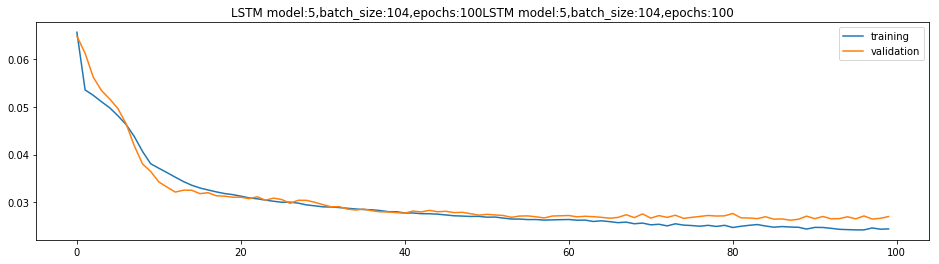

In [24]:
file_name = dt.datetime.today().strftime('%Y-%m-%d %H:%M')
Comment += "LSTM model:" + str(model_type) + ",batch_size:" + "104" + ",epochs:" + str(epochs_number)

# plot history
pyplot.figure(figsize=(16, 4))

pyplot.plot(history.history['loss'], label='training')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.title( Comment )
pyplot.savefig('Model Runs History/' + 'training-validation-' +  file_name  + '.pdf')
pyplot.show()

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 28, 20)            3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 20)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 15)                2160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 5,456
Trainable params: 5,456
Non-trainable params: 0
_________________________________________________________________


In [26]:
# MAKE A PREDICTION WITH TEST DATA

X = test2_X.copy() # inputs (features)
y = test2_y.copy() # targets
A = test2A.copy()
F = test2F.copy()
D = test2Dates.copy()

# make a prediction
yhat = model.predict(X)
# invert scaling for forecast
X = X.reshape((X.shape[0], n_days*n_features))
inv_yhat = concatenate((X[:,:n_features],yhat), axis=1)

if normalize_features == True:
    inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_f00 = inv_yhat[:,-n_days*n_features]
#inv_f01 = inv_yhat[:,-n_days*n_features+1]
inv_yhat = inv_yhat[:,-1] # the last column presents the prediction (t),(t+1),(t+2) [+predict_days-1]

if predict_days-1 > 0 :
    inv_yhat[predict_days-1:] = inv_yhat[:-predict_days+1] # since the prediction is for the future than shift to the future correleate w/ actual

    
# invert scaling for actual
y = y.reshape((len(y), 1)) # targets
inv_y = concatenate((X[:,-n_features:],y), axis=1)
if normalize_features == True:
    inv_y = scaler.inverse_transform(inv_y)



inv_yd = inv_y[:,-1-n_features] # actual daily counts (t-1),(t),(t+1),...
# shift daily actual counts 
inv_yd[:-1] = inv_yd[1:] #shift daily counts to get values for (t) from (t-1), the [0] gets lost, [-1] is empitied
inv_yd[-1] = numpy.nan




inv_y = inv_y[:,-1] # targets (t),(t+1),(t+2) [+predict_days-1]
# shift daily targets back (they were shifted into the past by predict_days)
if predict_days-1 > 0 :
    inv_y[predict_days-1:] = inv_y[:-predict_days+1]


# cut the tail predict_days 
if predict_days-1 > 0 :
    inv_prediction = inv_yhat[predict_days-1:-predict_days+1]
    inv_actuals = inv_yd[predict_days-1:-predict_days+1]
    inv_targets = inv_y[predict_days-1:-predict_days+1]
    inv_actualsA = A[predict_days-1:-predict_days+1]
    inv_featuresF = F[predict_days-1:-predict_days+1,:-1]
    inv_actualsDates = D[predict_days-1:-predict_days+1]

else:
    inv_prediction = inv_yhat[:-1]
    inv_actuals = inv_yd[:-1]
    inv_targets = inv_y[:-1]
    inv_actualsA = A[:-1]
    inv_featuresF = F[:-1,:-1]
    inv_actualsDates = D[:-1,:-1]

# seasonal adjuster
if substract_seasonal == True:
    seasonal_test = seasonal[-len(inv_prediction)-1:-1]
    inv_prediction += seasonal_test
    inv_actuals += seasonal_test
    inv_targets += seasonal_test
    dataset['Case No_RM'] += seasonal
    dataset['Count'] += seasonal
if split_seasonal_residuals == True:
    seasonal_test = seasonal[-len(inv_prediction)-1:-1]
    inv_actuals += seasonal_test
    dataset['Count'] += seasonal
    
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_actuals, inv_prediction))
print('Test RMSE: %.3f' % rmse)

from sklearn.metrics import mean_absolute_error

#calculate MAE
###mae = mean_absolute_error(inv_actuals, inv_prediction)
mae = mean_absolute_error(inv_actualsA[:,0], inv_prediction[:])
print('Test MAE: %.3f' % mae)

#calculate MAPE
#mape = mean_absolute_percentage_error(inv_actuals, inv_prediction)
mape = mean_absolute_percentage_error(inv_actualsA[:,0], inv_prediction)


print('Test MAPE: %.3f' % mape + '%')

# COMPARE ACTUALS WITH ROLLING AVERAGE
# calculate MAPE


#inv_rolling_actuals = rolling_average(inv_actuals)
inv_rolling_actuals = savitzky_golay(inv_actualsA[:,0],5,2)

mape2 = mean_absolute_percentage_error(inv_actualsA[0:len(inv_rolling_actuals),0],inv_rolling_actuals[:])
print('Actuals vs S-G MAPE: %.3f' % mape2 + '%')

# COMPARE ACTUALS WITH TARGETS
# calculate MAPE

#inv_y_ra = rolling_average(inv_targets)
#inv_y_ra = savitzky_golay(inv_targets,5,2)

mape3 = mean_absolute_percentage_error(inv_targets[0:len(inv_rolling_actuals)],inv_rolling_actuals)
print('Targets vs S-G MAPE: %.3f' % mape3 + '%')

mape4 = mean_absolute_percentage_error(inv_rolling_actuals,inv_prediction[0:len(inv_rolling_actuals)])
print('S-G vs Forecast MAPE: %.3f' % mape4 + '%')

Test RMSE: 127.298
Test MAE: 86.105
Test MAPE: 34.647%
Actuals vs S-G MAPE: 27.401%
Targets vs S-G MAPE: 0.055%
S-G vs Forecast MAPE: 21.052%


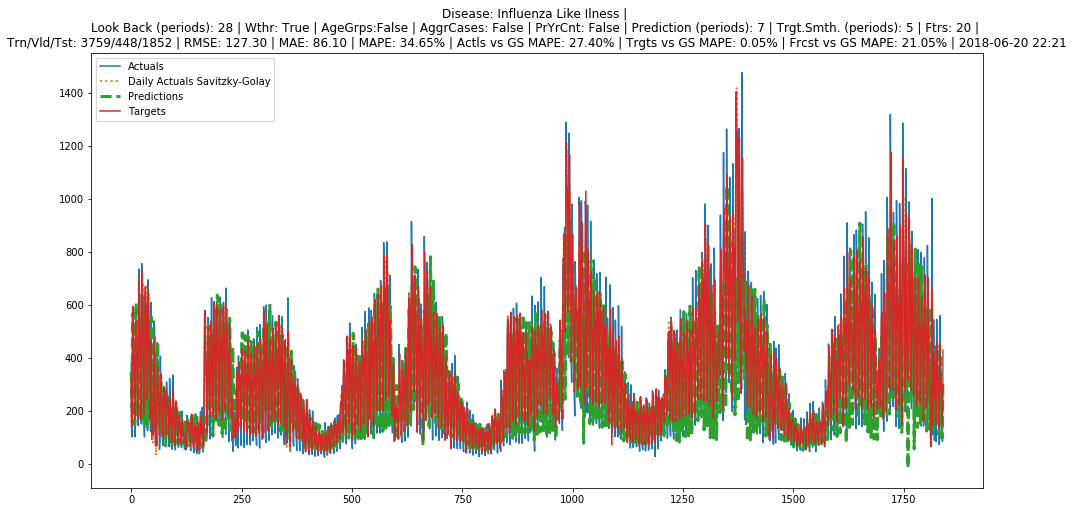

In [27]:
# plot baseline and predictions

pyplot.figure(figsize=(16, 8))
#pyplot.plot(inv_targets, label="Targets")
pyplot.title("Disease: " + Disease + " | \n" +
             "Look Back (periods): " + str(n_days) + " | " +
             "Wthr: " + str(include_weather)  + " | " +
             "AgeGrps:" + str(include_age_groups) + " | " +
             "AggrCases: " + str(Aggregate_Cases) + " | " +
             "PrYrCnt: " + str(include_case_count_year_before) + " | " +

             "Prediction (periods): " + str(predict_days) + " | " + 
             "Trgt.Smth. (periods): " + str(smoothing) + " | " +
             "Ftrs: " + str(n_features)  + " | \n" +
             
             "Trn/Vld/Tst: " + str(n_train_days) + "/" + str(n_test_days) + "/" + str(n_test2_days) + " | " +
             "RMSE: " + str("%.2f" % rmse) + " | " +
             "MAE: " + str("%.2f" % mae) + " | " +
             "MAPE: " + str("%.2f" % mape) + "% | " +
             "Actls vs GS MAPE: "  + str("%.2f" % mape2) + "% | " +
             "Trgts vs GS MAPE: "  + str("%.2f" % mape3) + "% | " +
             "Frcst vs GS MAPE: "  + str("%.2f" % mape4) + "% | " +
             file_name
            )

#pyplot.plot(inv_actuals, label="Daily Actuals") # daily actuals

pyplot.plot(inv_actualsA, label="Actuals") # daily actuals


#pyplot.plot(rolling_average(inv_actuals), label="Daily Actuals Rolling Average") #rolling average of the daily actuals
ts = pd.Series(inv_actualsA[:,0])
#pyplot.plot(ts.rolling(window=5,min_periods=1).mean(), label = "Daily Actuals Rolling AverageDF")

pyplot.plot(savitzky_golay(inv_actualsA[:,0],7,2), ':', label = "Daily Actuals Savitzky-Golay", linewidth=2.0)

pyplot.plot(inv_prediction,'--', label="Predictions", linewidth=3.0)  # prediction

pyplot.plot(inv_targets, label="Targets")  # targets
##pyplot.plot(rolling_average(inv_prediction),'--', "Targets Rolling Average")

if substract_seasonal == True:
    pyplot.plot(seasonal_test, '--', label="Seasonal")  # seasonal_test

pyplot.legend(loc="upper left")

pyplot.savefig('Model Runs History/' + 'graph-' +  file_name  + '.pdf')
pyplot.show()


import csv

with open('Model Runs History/' + 'data-' + file_name + '.csv', 'w') as file:
    writer=csv.writer(file)
    writer.writerow(inv_actualsDates)
    writer.writerow(inv_actualsA[:,0])
    writer.writerow(inv_prediction)

#print('Model Runs History/' + 'graph-' +  file_name  + '.pdf', "\n", 'Model Runs History/' + 'data-' + file_name + '.csv')



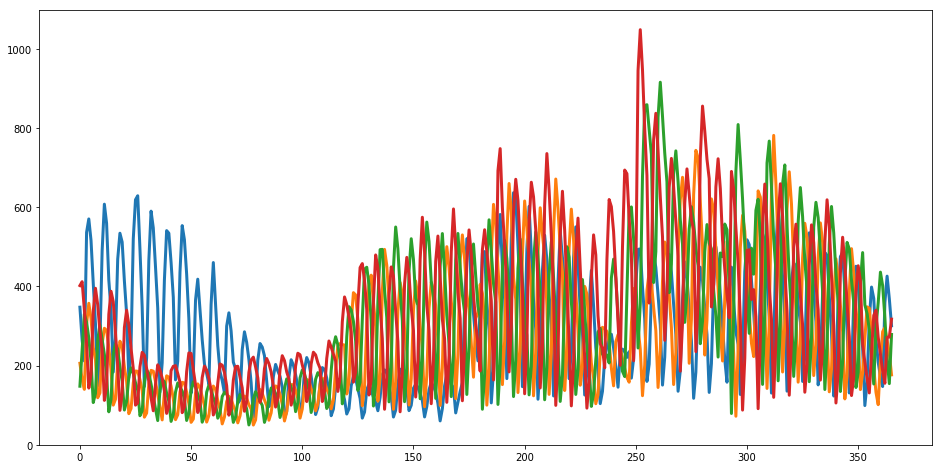

In [28]:
pyplot.figure(figsize=(16, 8))

for i in range(0,4):
    pyplot.plot(inv_prediction[i*year_length:min((i+1)*year_length,len(inv_prediction))], linewidth=3.0)  # prediction

pyplot.savefig('Model Runs History/' + 'stacked-predictions-' +  file_name  + '.pdf')
pyplot.show()

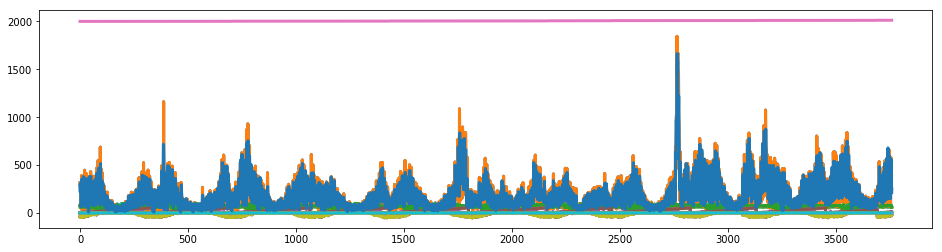

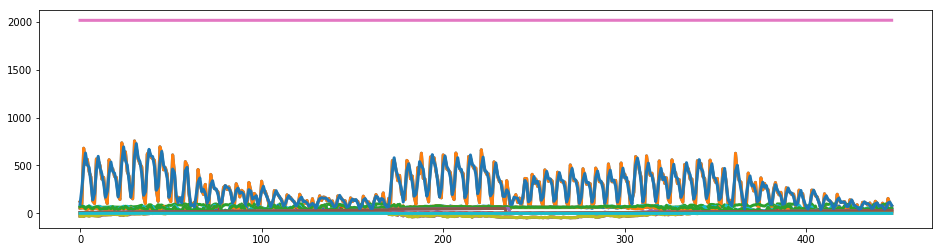

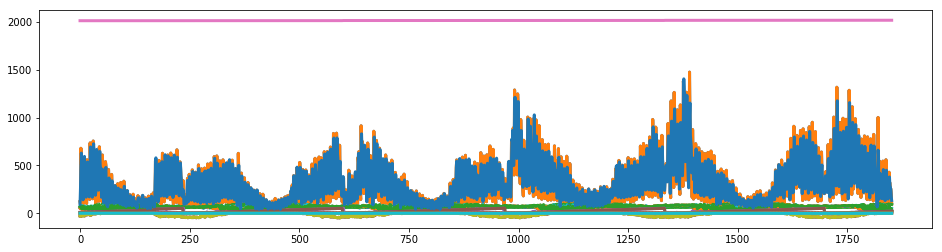

In [29]:
pyplot.figure(figsize=(16, 4))
pyplot.plot(trainF, linewidth=3.0)  # prediction
pyplot.show()

pyplot.figure(figsize=(16, 4))
pyplot.plot(testF, linewidth=3.0)  # prediction
pyplot.show()

pyplot.figure(figsize=(16, 4))
pyplot.plot(test2F, linewidth=3.0)  # prediction
pyplot.show()

2013-03-15


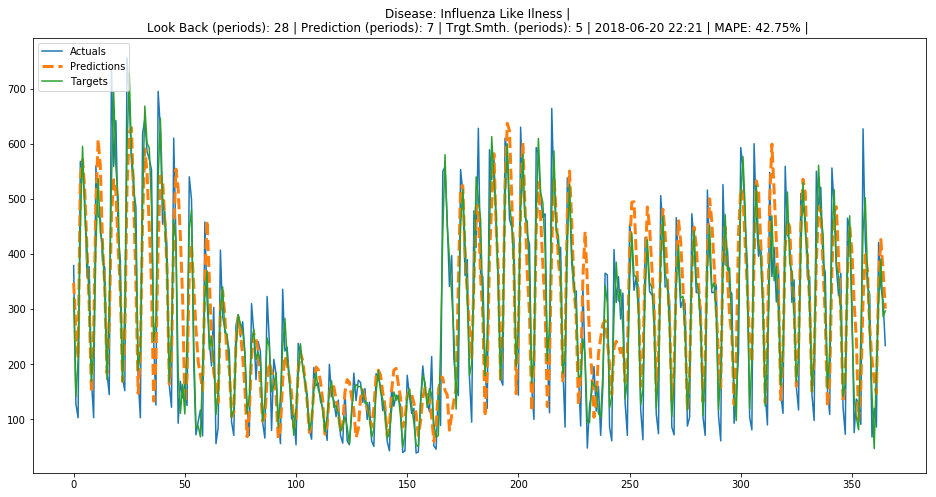

2014-05-16


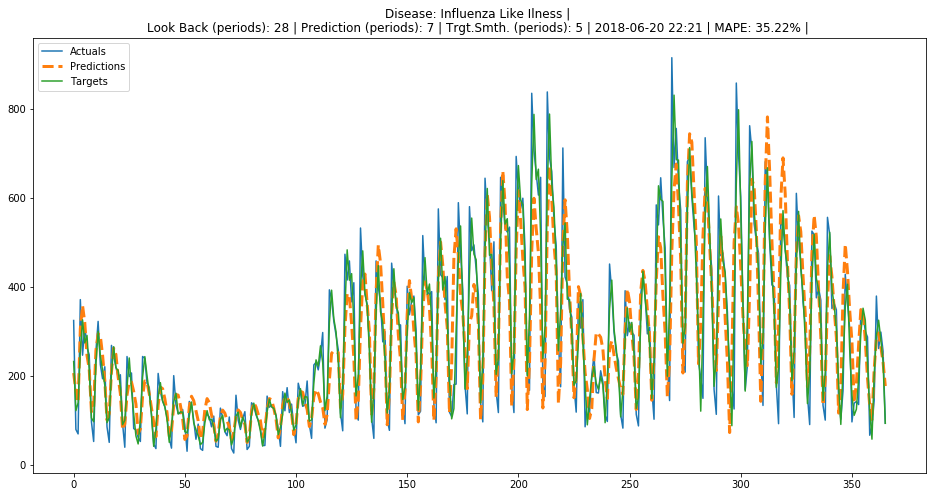

2015-05-17


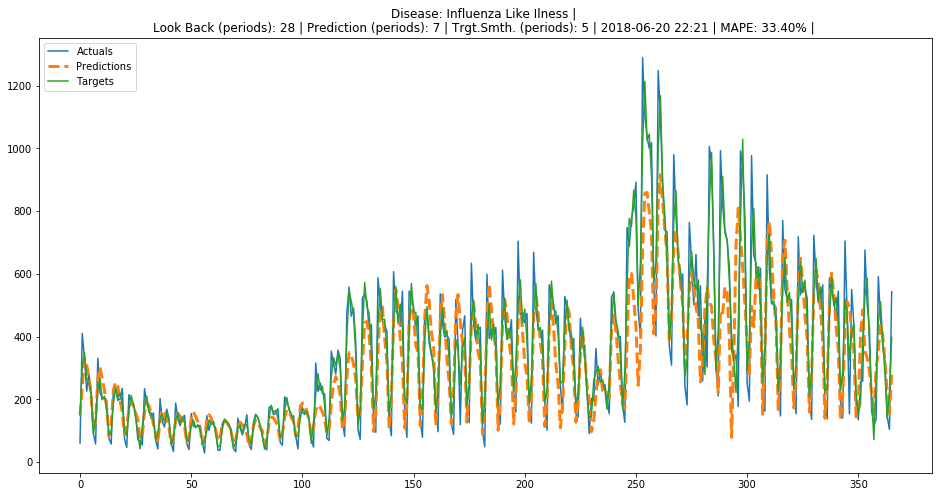

In [30]:
for year_number in range(0,3):
    i1 = year_number * year_length
    i2 = i1 + year_length
    
    pyplot.figure(figsize=(16, 8))
    #pyplot.plot(inv_targets, label="Targets")
    pyplot.title("Disease: " + Disease + " | \n" +
                 "Look Back (periods): " + str(n_days) + " | " +
                 "Prediction (periods): " + str(predict_days) + " | " + 
                 "Trgt.Smth. (periods): " + str(smoothing) + " | " +
                 file_name + " | " +
                 "MAPE: " + str("%.2f" % mean_absolute_percentage_error(inv_actualsA[i1:i2,0],inv_prediction[i1:i2])) + "% | "
                )

    print(inv_actualsDates[i1])
    pyplot.plot(inv_actualsA[i1:i2], label="Actuals") # daily actuals



    #pyplot.plot(rolling_average(inv_actuals), label="Daily Actuals Rolling Average") #rolling average of the daily actuals
    ts = pd.Series(inv_actualsA[:,0])
    #pyplot.plot(ts.rolling(window=5,min_periods=1).mean(), label = "Daily Actuals Rolling AverageDF")

    #pyplot.plot(savitzky_golay(inv_actuals,7,2), ':', label = "Daily Actuals Savitzky-Golay", linewidth=2.0)

    pyplot.plot(inv_prediction[i1:i2],'--', label="Predictions", linewidth=3.0)  # prediction

    pyplot.plot(inv_targets[i1:i2], label="Targets")  # targets


    ##pyplot.plot(rolling_average(inv_prediction),'--', "Targets Rolling Average")

    if substract_seasonal == True:
        pyplot.plot(seasonal_test, '--', label="Seasonal")  # seasonal_test

    pyplot.legend(loc="upper left")
    pyplot.savefig('Model Runs History/' + 'one-year-closeup-y1-' +  file_name  + '.pdf')

    import datetime as dt
    pyplot.show()